# DCGAN Project.

In this project we have trained a DCGAN on the AFHQ dataset to generate synthetic images of animals.

**Disclaimer:** Some of the code in this notebook has been generated using ChatGPT

In [ ]:
!pip install datasets torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# importing libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt


# Loading Dataset

The dataset is imported from hugging face using the datasets library. We have 16,130 images and three labels - cat,dog and wild.

In [ ]:
# Load dataset from Hugging Face
dataset = load_dataset("huggan/AFHQ", split="train")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


dataset_infos.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/358M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/371M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16130 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 16130
})


In [ ]:
print(dataset.features)

{'image': Image(mode=None, decode=True, id=None), 'label': ClassLabel(names=['cat', 'dog', 'wild'], id=None)}


In [ ]:
print(type(dataset))

<class 'datasets.arrow_dataset.Dataset'>


In [ ]:
# Check first item in the dataset
print(type(dataset[0]))
# Expected Output: <class 'dict'>

<class 'dict'>


In [ ]:
# Check type of image and label
print(type(dataset[0]['image']))  # Image type (PIL or array)
print(type(dataset[0]['label']))  # Label type (int or str)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'int'>


# Data Preprocessing

We perform the following transformation functions on the dataset:

1. The images are resized to 128x128 pixels.
2. Each channel of the rgb image is normalized.

In [ ]:
from torchvision import transforms

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),   # Resize images to 128x128
    transforms.ToTensor(),         # Convert to tensor (C, H, W)
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
  # Normalize to [-1, 1]
])

def transform_example(example):
    example["image"] = transform(example["image"])  # Apply transformation
    return example  # Ensure the structure stays unchanged

# Apply the transformation with batched=False
dataset = dataset.map(transform_example, batched=False)

# Convert dataset to PyTorch format explicitly
dataset.set_format(type="torch", columns=["image", "label"])




# Check transformation
print(type(dataset[0]['image']))  # Output: <class 'torch.Tensor'>


Map:   0%|          | 0/16130 [00:00<?, ? examples/s]

<class 'torch.Tensor'>


In [ ]:
print(type(dataset))  # Expected: <class 'datasets.arrow_dataset.Dataset'>
print(type(dataset[0]))  # Expected: <class 'dict'>
print(type(dataset[0]['image']))  # Expected: <class 'torch.Tensor'>


<class 'datasets.arrow_dataset.Dataset'>
<class 'dict'>
<class 'torch.Tensor'>


In [ ]:
for i in range(5):  # Check first 5 images
    img = dataset[i]["image"]
    print(f"Image {i} shape: {img.shape}")  # Expected: torch.Size([3, 64, 64])


Image 0 shape: torch.Size([3, 128, 128])
Image 1 shape: torch.Size([3, 128, 128])
Image 2 shape: torch.Size([3, 128, 128])
Image 3 shape: torch.Size([3, 128, 128])
Image 4 shape: torch.Size([3, 128, 128])


In [ ]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 64  # You can adjust this based on your GPU memory

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Check one batch
batch = next(iter(dataloader))
print(f"Batch image shape: {batch['image'].shape}")  # Expected: torch.Size([32, 3, 64, 64])
print(f"Batch label shape: {batch['label'].shape}")  # Expected: torch.Size([32])


Batch image shape: torch.Size([64, 3, 128, 128])
Batch label shape: torch.Size([64])


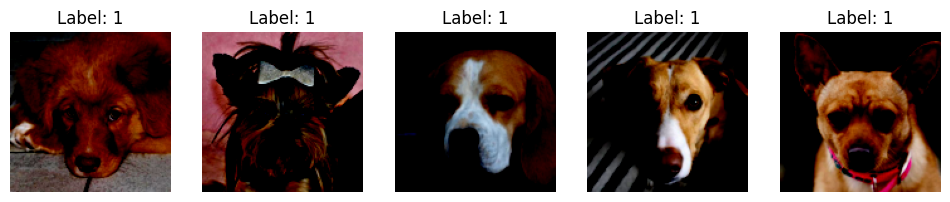

In [ ]:
# Function to show images
def denormalize(img):
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    img = img * std[:, None, None] + mean[:, None, None]  # Unnormalize
    return img.clamp(0, 1)  # Ensure values are in range [0,1]

def show_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

    for i in range(num_samples):
        img = dataset[i]["image"]  # Get image tensor
        img = img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) format

        label = dataset[i]["label"]  # Get label

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    plt.show()

# Show 5 random images
show_samples(dataset, num_samples=5)

Our GAN consists of two components:
1. Generator
2. Discriminator

For the generator architecture,our input is a later vector of 100 dimensions.Then we have transposed convolutional layers with batch normalization. The activation function is a ReLU function.



In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim=100, feature_maps=64, channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps, feature_maps // 2, 4, 2, 1, bias=False),  # Extra layer for 128x128
            nn.BatchNorm2d(feature_maps // 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps // 2, channels, 4, 2, 1, bias=False),

        )

    def forward(self, z):
        return torch.tanh(self.model(z))


The discriminator consists of spectrally normalized convolutional layers,with batch normalization and leaky ReLU activation function.

In [ ]:
from torch.nn.utils import spectral_norm

class Discriminator(nn.Module):
    def __init__(self, feature_maps=64, channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Conv2d(channels, feature_maps // 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(feature_maps // 2, feature_maps, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_maps),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),

            spectral_norm(nn.Conv2d(feature_maps * 8, 1, 4, 1, 0, bias=False)),

        )

    def forward(self, img):
        return self.model(img).view(-1, 1)


Our loss function is BCE with logits loss.Both the generator and discriminator have a learning rate of 0.0002. The Adam optimizer is used.

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Generator and Discriminator
latent_dim = 100
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizers


optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))



# Training Process
The model is trained for 65 epochs and images are generated after every 5 epochs to compare performance.

In [ ]:
import torchvision.utils as vutils
import os
os.makedirs("models", exist_ok=True)

epochs = 65
fixed_noise = torch.randn(16, latent_dim, 1, 1, device=device)  # Fixed noise for visualization

for epoch in range(epochs):
    for i, batch in enumerate(dataloader):
        real_images = batch["image"].to(device)
        batch_size = real_images.size(0)

        # Create labels
        real_labels = torch.full((batch_size, 1), 0.9, device=device)  # Instead of 1
        fake_labels = torch.full((batch_size, 1), 0.1, device=device)  # Instead of 0




        ## **Train Discriminator**
        optimizer_D.zero_grad()
        output_real = discriminator(real_images)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        output_fake = discriminator(fake_images.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        ## **Train Generator**

        optimizer_G.zero_grad()
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # Fresh noise for Generator
        fake_images = generator(noise)
        output = discriminator(fake_images)
        loss_G = -torch.mean(discriminator(fake_images))  # Maximizing generator scores
        loss_G.backward()
        optimizer_G.step()



        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}] | Step [{i}/{len(dataloader)}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

    # Save sample images every few epochs
    if epoch % 5 == 0:
        with torch.no_grad():
            fake_samples = generator(fixed_noise).cpu()
            vutils.save_image(fake_samples, f"generated_epoch_{epoch}.png", normalize=True)

# Save model weights
torch.save(generator.state_dict(), "models/generator.pth")
torch.save(discriminator.state_dict(), "models/discriminator.pth")

print("Training complete! Model weights and images saved.")


Epoch [0/65] | Step [0/253] | Loss D: 1.3268 | Loss G: 3.5512
Epoch [0/65] | Step [100/253] | Loss D: 0.9493 | Loss G: 4.1493
Epoch [0/65] | Step [200/253] | Loss D: 0.8120 | Loss G: 1.8182
Epoch [1/65] | Step [0/253] | Loss D: 0.9904 | Loss G: 1.6812
Epoch [1/65] | Step [100/253] | Loss D: 0.7099 | Loss G: 3.2438
Epoch [1/65] | Step [200/253] | Loss D: 0.9414 | Loss G: 1.6794
Epoch [2/65] | Step [0/253] | Loss D: 1.1034 | Loss G: 2.0391
Epoch [2/65] | Step [100/253] | Loss D: 0.8563 | Loss G: 1.4589
Epoch [2/65] | Step [200/253] | Loss D: 1.0747 | Loss G: 4.1092
Epoch [3/65] | Step [0/253] | Loss D: 1.6782 | Loss G: 4.4292
Epoch [3/65] | Step [100/253] | Loss D: 1.0059 | Loss G: 2.0734
Epoch [3/65] | Step [200/253] | Loss D: 1.0881 | Loss G: 2.4771
Epoch [4/65] | Step [0/253] | Loss D: 1.2092 | Loss G: 2.0835
Epoch [4/65] | Step [100/253] | Loss D: 1.0851 | Loss G: 1.6972
Epoch [4/65] | Step [200/253] | Loss D: 0.9926 | Loss G: 2.0394
Epoch [5/65] | Step [0/253] | Loss D: 1.5759 | Los

We save the weights of both models for loading.

In [ ]:
from google.colab import files

files.download("models/generator.pth")
files.download("models/discriminator.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We load the trained model and use it to generate synthetic images of animals.

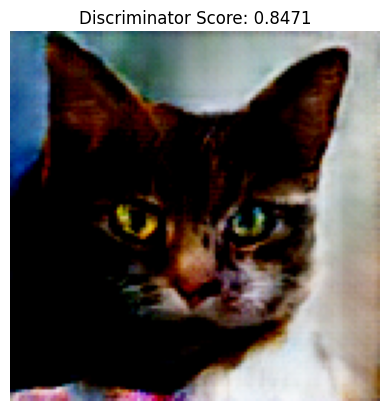

Generated image saved as generated_sample.png


In [ ]:
import torch
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define latent dimension (
latent_dim = 100

# Load the trained Generator and Discriminator
generator = Generator()
discriminator = Discriminator()

generator.load_state_dict(torch.load("models/generator.pth", map_location=device))
discriminator.load_state_dict(torch.load("models/discriminator.pth", map_location=device))

generator.to(device).eval()
discriminator.to(device).eval()

# Generate a new image
with torch.no_grad():
    noise = torch.randn(1, latent_dim, 1, 1, device=device)  # Generate a single random noise vector
    generated_image = generator(noise).cpu()

# Evaluate the image with the discriminator
with torch.no_grad():
    disc_output = discriminator(generated_image.to(device))
    confidence = torch.sigmoid(disc_output).item()  # Convert to probability

# Save the generated image
image_path = "generated_sample.png"
vutils.save_image(generated_image, image_path, normalize=True)

# Display the image with discriminator confidence score
plt.imshow(generated_image.squeeze(0).permute(1, 2, 0))
plt.axis("off")
plt.title(f"Discriminator Score: {confidence:.4f}")
plt.show()

print(f"Generated image saved as {image_path}")
